In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [2]:
training_data_filename = './training_data_PACE.npy'

In [3]:
import numpy as np

def augment_patch(patch, shape=(5, 5, 172)):
    """Generate augmented versions of a (h, w, c) patch"""
    patch = patch.reshape(shape)
    aug_patches = []

    # Original
    aug_patches.append(patch)
    
    # Horizontal flip
    aug_patches.append(np.flip(patch, axis=1))
    
    # Vertical flip
    aug_patches.append(np.flip(patch, axis=0))
    
    # Rotations
    aug_patches.append(np.rot90(patch, k=1, axes=(0, 1)))
    aug_patches.append(np.rot90(patch, k=2, axes=(0, 1)))
    aug_patches.append(np.rot90(patch, k=3, axes=(0, 1)))

    return [p.flatten() for p in aug_patches]


Loaded 231 entries from ./training_data_PACE.npy
Augmented dataset: 1386 samples, 4300 features
Model training complete.
Test Accuracy: 0.8921
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        71
           1       0.95      0.90      0.93       207

    accuracy                           0.89       278
   macro avg       0.85      0.88      0.86       278
weighted avg       0.90      0.89      0.89       278



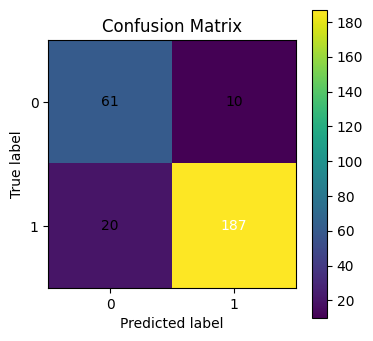

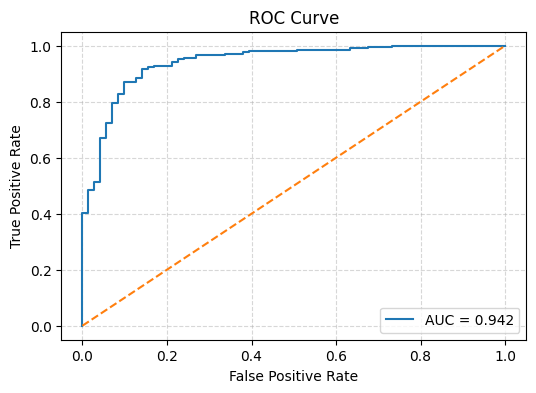

In [4]:
# Suppose `data` is your loaded array of entries, and you build X, y as before:
# e.g., data = np.load(..., allow_pickle=True); 
# each entry: (granule_name, some_id, labels_tuple, patch_array)
# Build lists:
if not os.path.exists(training_data_filename):
    raise FileNotFoundError(f"File '{training_data_filename}' not found. Please ensure the correct path and rerun.")

# Load the training data
data = np.load(training_data_filename, allow_pickle=True)
data = np.array([entry for entry in data if entry[2][5] > 10])

print(f"Loaded {len(data)} entries from {training_data_filename}")



# Determine feature vector size from first entry
first_entry = data[0]
if len(first_entry) < 3:
    raise ValueError("Unexpected entry format. Each entry should be (row_index, labels_array, patch_flat_array)")
first_patch = first_entry[3]
if not isinstance(first_patch, np.ndarray):
    raise ValueError("Patch data not found or not a numpy array.")


# Build augmented X and y
X_augmented = []
y_augmented = []

for entry in data:
    _, _, labels, patch_flat = entry

    patch_arr = np.nan_to_num(patch_flat, nan=0.0)

    try:
        
        aug_patches = augment_patch(patch_arr, shape=(5,5,172))  # Adjust shape if needed
    except Exception as e:
        print(f"Skipping entry due to error in augmentation: {e}")
        continue

    part = labels[4] if not np.isnan(labels[4]) else 0.0
    part = part if part != 0 else 0.01
    label = 1 if part >= 0.1 else 0

    for aug_patch in aug_patches:
        X_augmented.append(aug_patch)
        y_augmented.append(label)

X = np.array(X_augmented)
y = np.array(y_augmented)

print(f"Augmented dataset: {X.shape[0]} samples, {X.shape[1]} features")

n_samples = len(data)
indices = np.arange(n_samples)

# Now split indices and labels; use indices to index X later
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

try:
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
except ImportError as e:
    raise ImportError("scikit-learn is required for this cell. Please install it (e.g., `pip install scikit-learn`).") from e

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
# For high-dimensional data, use solver='saga' or 'liblinear'; adjust max_iter as needed
model = LogisticRegression(
    solver='saga',
    max_iter=10000,
    class_weight = 'balanced',
    random_state=42)
model.fit(X_train_scaled, y_train)
print("Model training complete.")

# Evaluate on test set
y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.xticks([0, 1])
plt.yticks([0, 1])
# Annotate counts
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

# ROC curve
# Only if both classes present in test set
if len(np.unique(y_test)) == 2:
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True, ls='--', alpha=0.5)
    plt.show()
else:
    print("Cannot plot ROC: only one class present in y_test.")

In [5]:
len(X_train[0])

4300

Model training complete.
Test Accuracy: 0.8921
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        71
           1       0.95      0.90      0.93       207

    accuracy                           0.89       278
   macro avg       0.85      0.88      0.86       278
weighted avg       0.90      0.89      0.89       278



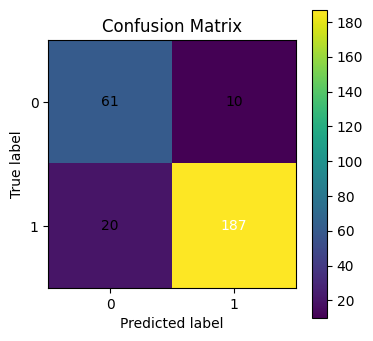

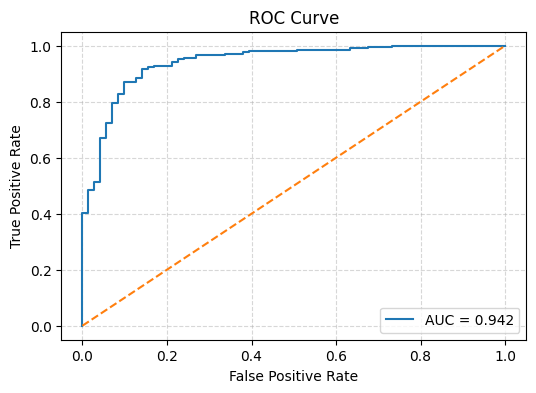

In [6]:
# Attempt to import sklearn; if not installed, prompt user
try:
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
except ImportError as e:
    raise ImportError("scikit-learn is required for this cell. Please install it (e.g., `pip install scikit-learn`).") from e


# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
# For high-dimensional data, use solver='saga' or 'liblinear'; adjust max_iter as needed
model = LogisticRegression(
    solver='saga',
    max_iter=10000,
    class_weight = 'balanced',
    random_state=42)
model.fit(X_train_scaled, y_train)
print("Model training complete.")

# Evaluate on test set
y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.xticks([0, 1])
plt.yticks([0, 1])
# Annotate counts
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

# ROC curve
# Only if both classes present in test set
if len(np.unique(y_test)) == 2:
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True, ls='--', alpha=0.5)
    plt.show()
else:
    print("Cannot plot ROC: only one class present in y_test.")



In [ ]:
# Continue scaling/training on X_train, y_train, etc.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='saga', max_iter=10000, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(X_test_scaled)

# Find misclassified indices (relative to the original data)
mis_mask = (y_pred != y_test)
mis_test_indices = test_idx[mis_mask]  # these are indices into the original data array

# Recover granule names for misclassified samples
mis_granule_names = [granule_names[i] for i in mis_test_indices]
mis_station_names = [station_names[i] for i in mis_test_indices]

print(f"Number of misclassified samples in test set: {len(mis_granule_names)}")
for i in range(10):
    print("Some stations:", mis_granule_names[i], '-', mis_station_names[i])

In [ ]:
# Continue scaling/training on X_train, y_train, etc.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='saga', max_iter=10000, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(X_test_scaled)

false_mask = (y_pred == 0)
false_mask_indices = test_idx[false_mask]  # these are indices into the original data array

true_mask = (y_pred == 1)
true_mask_indices = test_idx[true_mask]  # these are indices into the original data array

# Recover granule names for misclassified samples
f_chla = [chls[i] for i in false_mask_indices]
t_chla = [chls[i] for i in true_mask_indices]


In [ ]:
bins = 64
all_data = f_chla + t_chla  # combine to set common range
range_min, range_max = min(all_data), max(all_data)

# Plot
plt.hist(f_chla, bins=bins, range=(range_min, 500), color='red', alpha=0.5, label='False')
plt.hist(t_chla, bins=bins, range=(range_min, 500), color='blue', alpha=0.5, label='True')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Two Arrays')
plt.legend()
plt.show()

In [ ]:
f_chla